# Dowloading the Datasets and becoming familiar with the data

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [3]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT/"

## Preprocessing the data

In [5]:
# Creating the function to read lines from the document
def get_lines(filename):
    """
    Reads filename (a text file) and returns the lines of text as a list.

    Args:
        filename: a string contaning the target filepath.

    Returns:
        A list of strings with one string per line from the target filename.
    """

    with open(filename) as f:
        return f.readlines()

In [6]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:3]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .\n']

### We need the data in the following format to be able to use it with our model 

```
[{  'line_number' : 0,
    'target' : 'BACKGROUND',
    'text' : 'Emotional eating is the leading cause of Obesity',
    'total_lines' : 11
}]
```

In [7]:
# Creating a function to preprocess the data
def preprocess_text(filename):
    """
    Args: 
        filename : filename: a string contaning the target filepath.
    Returns:
        A list of dictionaries, of abstract line data.
    """

    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()

            # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t") # split the label from text
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_line_split) - 1
                abstract_samples.append(line_data)
        else:
            abstract_lines += line

    return abstract_samples 

In [8]:
# Get the data from the file and preprocess it
train_samples = preprocess_text(data_dir + "train.txt")
test_samples = preprocess_text(data_dir + "test.txt")
val_samples = preprocess_text(data_dir + "dev.txt")

print(f"Length of training samples: {len(train_samples)}")
print(f"Length of training samples: {len(test_samples)}")
print(f"Length of training samples: {len(val_samples)}")

Length of training samples: 180040
Length of training samples: 30135
Length of training samples: 30212


In [9]:
# Converting our lists into Pandas dataframes
import pandas as pd
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)

train_df.head(5)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of 6 weeks of dail...,0,11
1,METHODS,a total of 125 patients with primary knee oa w...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


# Getting data ready for our model

Our model will have 4 different inputs 

    1. Line Numbers (One Hot Encoded)
    2. Total Lines (One Hot Encoded)
    3. Train Sentences (Custom Token Embeddings)
    4. Train Chars (Custom character embeddings)

And output will be target Label which we will also encode



In [10]:
# Encoding labels OneHot and LabelEncode
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
label_encoder = LabelEncoder()

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())

print(f"\nTrain Labels One Hot Encoded: {train_labels_one_hot}\n")
print(f"\nTrain Labels Encoded: {train_labels_encoded}\n")


Train Labels One Hot Encoded: [[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


Train Labels Encoded: [3 2 2 ... 4 1 1]



In [11]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

## Preparing the text data for our model

In [12]:
# Connverting out sentences tolist
train_sentences = train_df["text"].tolist()
test_sentences = test_df["text"].tolist()
val_sentences = val_df["text"].tolist()

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len  = np.mean(sent_lens)
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

### Creating a Word Level Tokenizer and Embedding

In [14]:
# Total Words in our Dataset
MAX_TOKENS = 68000 # from the paper

# Creating a TextVectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = MAX_TOKENS, output_sequence_length = output_seq_len)
text_vectorizer.adapt(train_sentences)

In [15]:
# How many words in our training vocabulary?
rct_text_vocab = text_vectorizer.get_vocabulary()
print(f"No. of words in vocab: {len(rct_text_vocab)}")
print(f"Most common words in vocab: {rct_text_vocab[:5]}")
print(f"Least common words in data: {rct_text_vocab[-5:]}")

No. of words in vocab: 68000
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in data: ['httpsuploaduminacjpcgiopenbinctrctrcgifunctionbrowsactionbrowstypesummaryrecptnor000008238languagee', 'httpsregisterclinicaltrialsgov', 'httpsmartmicrosurgerycom', 'httpseudractemaeuropaeuindexhtml', 'httpseudractemaeuropaeu']


In [16]:
# Creating a custom token embedding
from tensorflow.keras.layers import Embedding

token_embed = Embedding(input_dim = len(rct_text_vocab),
                        output_dim = 512,
                        mask_zero = True,
                        name = "token_embeddings")

### Creating a character level tokenizer and embedding

In [17]:
# Make a function to split sentences into character
def split_chars(text):
    return " ".join(list(text))

# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

# Average character length in a sentence
char_lens = [len(sentence) for sentence in train_sentences]
output_seq_char_len = int(np.percentile(char_lens, 95))

# Getting all the possible chars in the sentences
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens= NUM_CHAR_TOKENS,
                                 output_sequence_length = output_seq_char_len,
                                 standardize = None,
                                 name = "char_vectorizer")

char_vectorizer.adapt(train_chars)
char_vocab = char_vectorizer.get_vocabulary()
print(f"No of different characters in character voacb: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 most common characters: {char_vocab[-5:]}")

No of different characters in character voacb: 69
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 most common characters: ['{', '@', '|', '"', '\\']


In [18]:
# Creating an embedding layer
char_embed = layers.Embedding(input_dim = len(char_vocab),
                              output_dim = 25, # this is the size of char_embedding in paper
                              mask_zero = True,
                              name = "char_embed")

### One hot Encoding the Line Number and Total Lines

In [19]:
# Use tensorflow to create one hot encoded tensors of line number and total lines
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

In [20]:
def create_prefetch_dataset(line_numbers, total_lines, sentences, chars, labels, batch_size):
    """
    Args:
        line_numbers: line numbers ONE HOT ENCODED
        total_lines: total_lines ONE HOT ENCODED
        sentences: list of sentences
        chars: list of characters
        batch_size: Number of batches
        labels: Labels ONE HOT ENCODED

    Returns: 
        Prefetch tensorflow dataset for efficient performance
    """

    char_token_pos_data = tf.data.Dataset.from_tensor_slices((line_numbers,
                                                              total_lines,
                                                              sentences,
                                                              chars))
    
    char_token_pos_labels = tf.data.Dataset.from_tensor_slices(labels)

    char_token_pos_dataset = tf.data.Dataset.zip((char_token_pos_data, char_token_pos_labels))

    char_token_pos_dataset = char_token_pos_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return char_token_pos_dataset

In [21]:
# Creating the fast loading prefetch datasets
train_char_token_pos_dataset = create_prefetch_dataset(train_line_numbers_one_hot,
                                                       train_total_lines_one_hot,
                                                       train_sentences,
                                                       train_chars,
                                                       train_labels_one_hot,
                                                       32)

test_char_token_pos_dataset = create_prefetch_dataset(test_line_numbers_one_hot,
                                                       test_total_lines_one_hot,
                                                       test_sentences,
                                                       test_chars,
                                                       test_labels_one_hot,
                                                       32)

val_char_token_pos_dataset = create_prefetch_dataset(val_line_numbers_one_hot,
                                                       val_total_lines_one_hot,
                                                       val_sentences,
                                                       val_chars,
                                                       val_labels_one_hot,
                                                       32)

## Creating a Tribrid Model with Custom Token and Word Embeddings

In [22]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Concatenate, Dropout

# 1. Token Inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_vectors = text_vectorizer(token_inputs)
token_embeddings = token_embed(token_vectors)
tokens_bi_lstm = Bidirectional(LSTM(32))(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = tokens_bi_lstm,
                             name = "token_model")

# 2. Character Inputs
char_input = Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_input)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = Bidirectional(LSTM(32))(char_embeddings)
char_model = Model(inputs = char_input, outputs = char_bi_lstm, name="char_model")

# 3. Line Numbers
line_numbers_input = Input(shape=(15,), dtype=tf.float32, name="line_number_input")
x = Dense(256, activation="relu")(line_numbers_input)
line_numbers_model = Model(inputs = line_numbers_input, outputs = x, name="line_numbers_model")

# 4. Total Lines
total_lines_input = Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = Dense(256, activation="relu")(total_lines_input)
total_lines_model = Model(inputs = total_lines_input, outputs = y, name="total_lines_model")

# 5. Concatenate the token and char into hybrid embeddings
hybrid = Concatenate(name="hybrid_token_char_embeddings")([token_model.output, char_model.output])
z = Dense(256, activation="relu")(hybrid)
hybrid_embeddings = Dropout(0.5)(z)

# 6. Combine positional and hybrid embeddings
tribrid_embeddings = Concatenate(name="tribrid_embeddings")([line_numbers_model.output,
                                                             total_lines_model.output,
                                                             hybrid_embeddings])

# 7. Final Output layer
output = Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Putting togathere everything
tribrid_model = Model(inputs = [line_numbers_model.input,
                                total_lines_model.input,
                                token_model.input,
                                char_model.input],
                      outputs = output,
                      name = "tribrid_model")

In [23]:
tribrid_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                      optimizer="adam",
                      metrics = ["accuracy"])

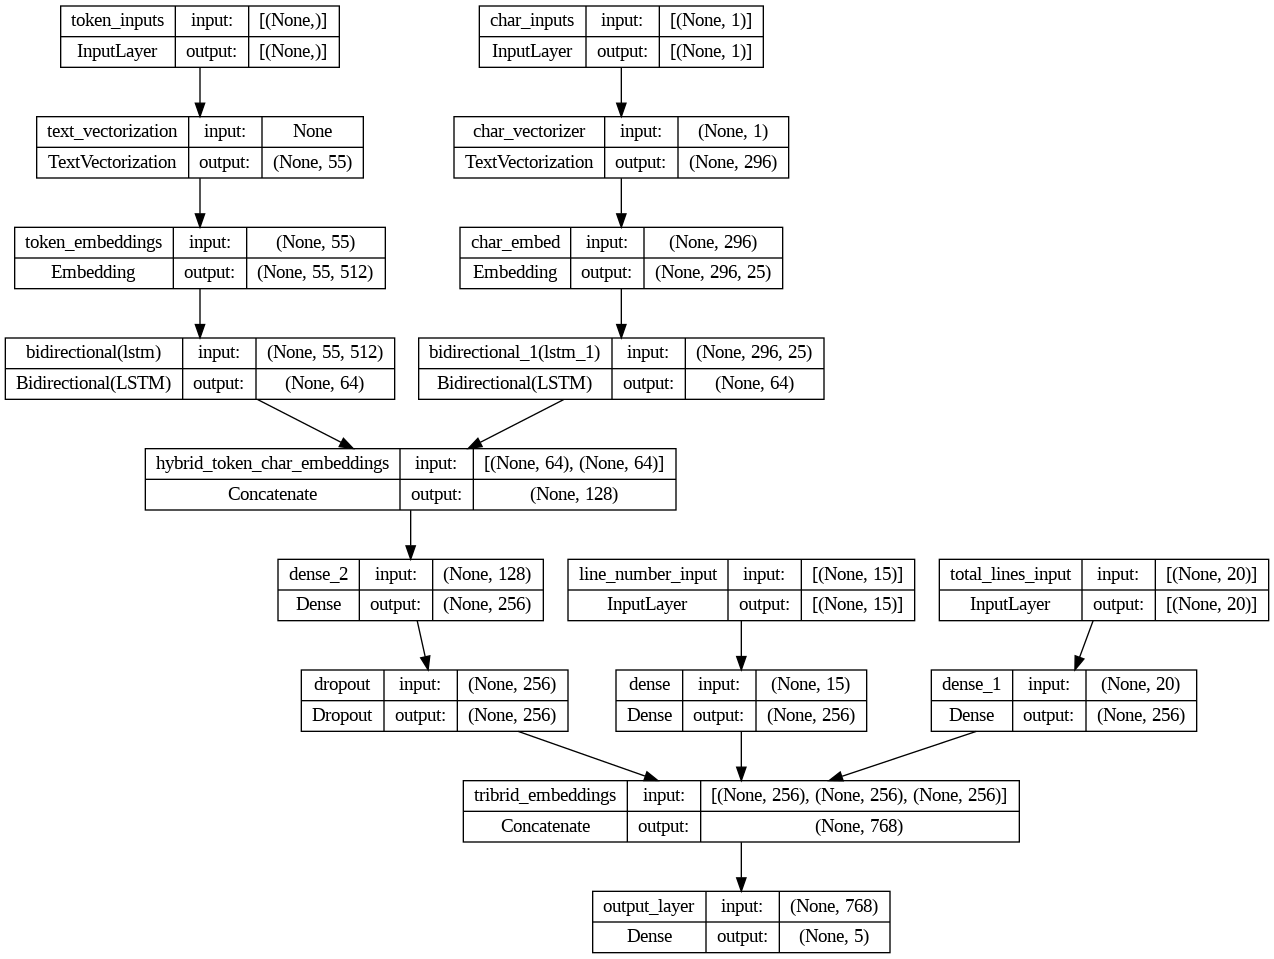

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(tribrid_model, show_shapes=True)

In [25]:
train_char_token_pos_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [26]:
tribrid_model_history = tribrid_model.fit(train_char_token_pos_dataset,
                                          steps_per_epoch=int(0.1* len(train_char_token_pos_dataset)),
                                          epochs=3,
                                          validation_data = val_char_token_pos_dataset,
                                          validation_steps = int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 82s 99ms/step - loss: 1.0143 - accuracy: 0.7800 - val_loss: 0.9198 - val_accuracy: 0.8441
Epoch 2/3
562/562 [==============================] - 32s 57ms/step - loss: 0.9132 - accuracy: 0.8515 - val_loss: 0.8978 - val_accuracy: 0.8534
Epoch 3/3
562/562 [==============================] - 29s 52ms/step - loss: 0.8976 - accuracy: 0.8585 - val_loss: 0.8871 - val_accuracy: 0.8620


In [27]:
!wget https://raw.githubusercontent.com/r-zeeshan/foodVision101-efficientNetB3/main/helper_functions.py
from helper_functions import calculate_results

--2023-02-26 09:46:00--  https://raw.githubusercontent.com/r-zeeshan/foodVision101-efficientNetB3/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12523 (12K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  12.23K  --.-KB/s    in 0s      

2023-02-26 09:46:00 (112 MB/s) - ‘helper_functions.py.1’ saved [12523/12523]



In [28]:
tribrid_model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.8816 - accuracy: 0.8649


[0.8815892934799194, 0.8649212121963501]

In [30]:
tribrid_model_pred_probs = tribrid_model.predict(test_char_token_pos_dataset)
tribrid_model_preds = tf.argmax(tribrid_model_pred_probs, axis=1)

942/942 [==============================] - 20s 16ms/step


In [31]:
tribrid_model_results = calculate_results(y_true = test_labels_encoded,
                                          y_pred = tribrid_model_preds) 

In [32]:
tribrid_model_results

{'accuracy': 86.07599137215863,
 'precision': 0.8605826495223277,
 'recall': 0.8607599137215862,
 'f1': 0.8602844491698982}